# Data functionalities

> Generating and importing data

In [1]:
from types import SimpleNamespace
from torchvision.datasets import MNIST

In [2]:
PATH = "."

In [3]:
mnist = MNIST(PATH, download=True)
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

In [4]:
mnist.data.shape

torch.Size([60000, 28, 28])

## Visualizing the dataset

In [5]:
from utils import show_image, show_images

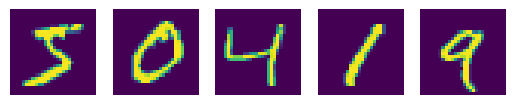

In [6]:
show_images(mnist.data[0:5]);

## Generating moving mnist sequences:

In [7]:
import random

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

We can leverage torchvision's affine transform!

In [8]:
digit = torch.tensor(mnist.data[[0]])

<AxesSubplot: >

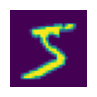

In [9]:
show_image(digit)

In [10]:
angle = 20  # rotation in degrees
scale = 1.3 # scaling in percentage (1.0 = no scaling)
translate = (2,3) # translation in pixels
shear = 15 # deformation on the z-plane

<AxesSubplot: >

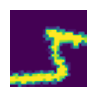

In [11]:
show_image(TF.affine(digit, angle, translate, scale, shear))

we should probably pad first, so we don't get out of the canvas

In [12]:
def padding(img_size=128, mnist_size=28): return (img_size - mnist_size) // 2

In [13]:
padding(64)

18

<AxesSubplot: >

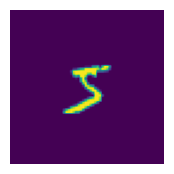

In [14]:
pdigit = TF.pad(digit, padding=18)  #18 give us a 64x64 image (18x2 + 28)
show_image(pdigit)

<AxesSubplot: >

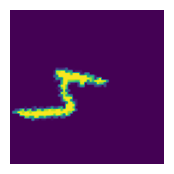

In [15]:
show_image(TF.affine(pdigit, angle, (-10,3), scale, shear))

In [16]:
def linear_schedule(a, b, n=5):
    "equivalent to np.linspace"
    return [i*(b-a)/(n-1) + a for i in range(n)]

In [17]:
linear_schedule(1,20)

[1.0, 5.75, 10.5, 15.25, 20.0]

In [18]:
angles = linear_schedule(-10,20)
angles

[-10.0, -2.5, 5.0, 12.5, 20.0]

In [19]:
affine_params = SimpleNamespace(
    angle=(-20, 20),
    translate=((-10, 10), (-10, 10)),
    scale=(.8, 1.3),
    shear=(-20, 20),
)

In [20]:
def random_linear_schedule(a, b, n=5):
    x = random.uniform(a,b)
    y = random.uniform(a,b)
    return linear_schedule(x, y, n=n)

In [21]:
random_linear_schedule(-10, 2)

[-3.6889156655237,
 -4.19994870854539,
 -4.710981751567081,
 -5.222014794588771,
 -5.733047837610462]

In [22]:
random_linear_schedule(.8, 1.3)

[1.0048579373284652,
 1.0176675252192946,
 1.0304771131101238,
 1.043286701000953,
 1.0560962888917824]

In [23]:
class Trajectory:
    def __init__(self, angle, translate, scale, shear, n=5):
        self.angle_schedule = random_linear_schedule(*angle, n=n)
        self.scale_schedule = random_linear_schedule(*scale, n=n)
        translate_x = random_linear_schedule(*translate[0], n=n)
        translate_y = random_linear_schedule(*translate[1], n=n)
        self.translate_schedule = list(zip(translate_x, translate_y))
        self.shear_schedule = random_linear_schedule(*shear, n=n)
        
    def points(self):
        return list(zip(self.angle_schedule , self.translate_schedule, self.scale_schedule, self.shear_schedule))
            
    def apply(self, img):
        return [TF.affine(img, *param) for param in self.points()]

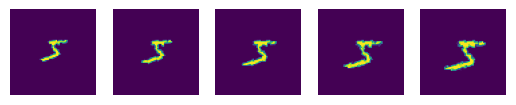

In [24]:
t = Trajectory(**vars(affine_params))
show_images([TF.affine(pdigit, *param) for param in t.points()])

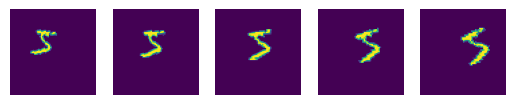

In [25]:
params = Trajectory(**vars(affine_params))
show_images(params.apply(pdigit))

In [166]:
import random
import torch
import numpy as np

class MovingMNIST:
    def __init__(self, mnist, affine_params: dict, num_digits: list[int]=[1, 2], n: int=4, img_size=64, concat=False):
        self.mnist = mnist.data
        self.affine_params = affine_params
        self.num_digits = num_digits
        self.n = n
        self.img_size = img_size
        self.pad = padding(img_size)
        self.concat = concat
    
    def random_digit(self):
        img = self.mnist[[random.randint(0, len(self.mnist))]]
        return TF.pad(img, padding=self.pad) 
    
    def random_trajectory(self):
        return Trajectory(**self.affine_params, n=self.n)
    
    def _one_moving_digit(self):
        digit = self.random_digit()
        traj = self.random_trajectory()
        return torch.stack(traj.apply(digit))
    
    def __getitem__(self, i):
        moving_digits = torch.stack([self._one_moving_digit() for _ in range(random.choice(self.num_digits))])
        return moving_digits.max(dim=0)[0]

This is an random MNIST Dataset:

In [167]:
mnist[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [168]:
vars(affine_params)

{'angle': (-20, 20),
 'translate': ((-10, 10), (-10, 10)),
 'scale': (0.8, 1.3),
 'shear': (-20, 20)}

In [169]:
ds = MovingMNIST(mnist, vars(affine_params))

torch.Size([4, 1, 64, 64])


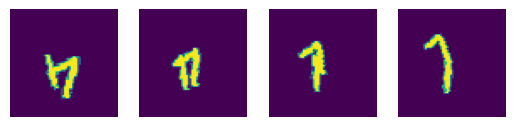

In [201]:
digits = ds[0]
print(digits.shape)
show_images(digits)